Data from: https://www.datascience4business.com/01_pdsm-tps-optin-a that is a version of: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

The major difference between this two sources are that 3 columns are missing from one to the other: MonthlyRate, HourlyRate, DailyRate. This will not affect the results since there were columns that we could not understood completely and their information could be replaced by MonthlyIncome. Also, there are missing values in the first one but not in the second. I discover this, after the missing values analysis, when trying to reproduce the results in the second dataset. 

This project is intended to understand and quantify the problem of the employees attrition. I will try to model and automatize the notification of the employers with more risk to quit and analyze the reasons why they are leaving. 

Since the dataset is in spanish, I will keep a dictionary to translate the name of the columns

In [1]:
spanish_english_cols_dict = {'edad': 'age', 'abandono': 'attrition', 'viajes': 'travel', 'departamento': 'department',
                             'distancia_casa': 'distance_home', 'educacion': 'education', 'carrera': 'career', 
                             'empleados': 'employees', 'satisfaccion_entorno': 'env_satisfaction', 'sexo': 'sex',
                             'implicacion': 'implication', 'nivel_laboral': 'labour_level', 'puesto': 'job',
                             'satisfaccion_trabajo': 'job_satisfaction', 'estado_civil': 'marital_status',
                             'salario_mes': 'monthly_salary', 'num_empresas_anteriores': 'num_previous_companies',
                             'mayor_edad': 'is_adult', 'horas_extra': 'extra_hours', 
                             'incremento_salario_porc': 'perc_salary_improvement', 'evaluacion': 'evaluation',
                             'satisfaccion_companeros': 'coworkers_satisfaction', 'horas_quincena': 'fortnight_hours',
                             'nivel_acciones': 'action_level', 'anos_experiencia': 'years_experience',
                             'num_formaciones_ult_ano': 'num_education_last_year', 'conciliacion': 'reconciliation', 
                             'anos_compania': 'years_company', 'anos_en_puesto': 'years_in_job', 
                             'anos_desde_ult_promocion': 'years_since_last_promotion',
                             'anos_con_manager_actual': 'years_with_current_manager'}

spanish_english_values = {'Universitaria': 'University', 'Secundaria': 'Secondary', 'Primaria': 'Elementary', 
                          'Alta': 'High', 'Muy_Alta': 'Very_High', 'Media': 'Medium', 'Baja': 'Low'}

In [2]:
from itertools import chain, combinations

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import jaccard_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

from tools.file_manager_workflows.model_file_manager_workflows import SaveWorkflow, LoadWorkflow
import tools.extend_pandas
from tools.models.transformers.base import NoTransformer
from tools.models.transformers.categorical import OneHotTargetedTransformer, OrdinalTargetedTransformer
%load_ext autoreload
%autoreload 2

In [3]:
ds_attrition = pd.read_csv('data/AbandonoEmpleados.csv', sep=';')
ds_attrition.columns = pd.Series(ds_attrition.columns).replace(spanish_english_cols_dict)
ds_attrition.replace(spanish_english_values, inplace=True)
ds_attrition.dtypes

age                             int64
attrition                      object
travel                         object
department                     object
distance_home                   int64
education                      object
career                         object
employees                       int64
id                              int64
env_satisfaction               object
sex                           float64
implication                    object
labour_level                    int64
job                            object
job_satisfaction               object
marital_status                 object
monthly_salary                  int64
num_previous_companies          int64
is_adult                       object
extra_hours                    object
perc_salary_improvement         int64
evaluation                     object
coworkers_satisfaction         object
fortnight_hours                 int64
action_level                    int64
years_experience                int64
num_educatio

In [4]:
ds_attrition.head()

,age,attrition,travel,department,distance_home,education,career,employees,id,env_satisfaction,...,coworkers_satisfaction,fortnight_hours,action_level,years_experience,num_education_last_year,reconciliation,years_company,years_in_job,years_since_last_promotion,years_with_current_manager
0,41,Yes,Travel_Rarely,Sales,1,University,Life Sciences,1,1,Medium,...,Low,80,0,8,0,#N/D,6,NaN,0,5
1,49,No,Travel_Frequently,Research & Development,8,Secondary,Life Sciences,1,2,High,...,Very_High,80,1,10,3,#N/D,10,NaN,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,Secondary,Other,1,4,Very_High,...,Medium,80,0,7,3,#N/D,0,2.0,0,0
3,33,No,Travel_Frequently,Research & Development,3,University,Life Sciences,1,5,Very_High,...,High,80,0,8,3,#N/D,8,3.0,3,0
4,27,No,Travel_Rarely,Research & Development,2,University,Medical,1,7,Low,...,Very_High,80,1,6,3,#N/D,2,NaN,2,2


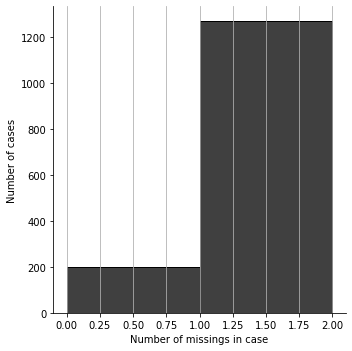

In [5]:
ds_attrition.missing.analysis.missing_case_plot()

# Data Quality

I will analyze the completeness, uniqueness and validity of the data and I will take for granted the timeliness, the consistency and the accuracy of the data.

## Completeness: missing values

The best technique I found to find out missing values, since there are not necessarily NaN but can be any value, is making a frequency table in order to see if there is any value that can represent the missing value, and what percentage it represents. But what it is true, is that the id ends in 2068 and there is 1470 rows so this dataset has some implicit missing data since there are missing employees.

## Uniqueness

The id column ensures the uniqueness of each row and looking at the frequency table, we can see that there is no duplicates in this dataset

## Validity

With the frequency table, we can see if there is any possible error outlier or value that does not make sense considering the meaning of the column, for instance, an age of 1500. There is no wrong values at first sight.

In [6]:
ds_attrition.columns

Index(['age', 'attrition', 'travel', 'department', 'distance_home',
       'education', 'career', 'employees', 'id', 'env_satisfaction', 'sex',
       'implication', 'labour_level', 'job', 'job_satisfaction',
       'marital_status', 'monthly_salary', 'num_previous_companies',
       'is_adult', 'extra_hours', 'perc_salary_improvement', 'evaluation',
       'coworkers_satisfaction', 'fortnight_hours', 'action_level',
       'years_experience', 'num_education_last_year', 'reconciliation',
       'years_company', 'years_in_job', 'years_since_last_promotion',
       'years_with_current_manager'],
      dtype='object')

In [7]:
possible_columns_with_na = ds_attrition.missing.analysis.missing_scan_count_with_default_na_representation(show_zeros=False)
display(possible_columns_with_na)
ds_attrition.missing.analysis.print_value_counts_per_column(variables=possible_columns_with_na['variable'])

,variable,n,pct,original_type
5,education,101,6.870748,object
8,id,1,0.068027,int64
11,implication,18,1.224490,object
14,job_satisfaction,76,5.170068,object
17,num_previous_companies,197,13.401361,int64
24,action_level,631,42.925170,int64
25,years_experience,11,0.748299,int64
26,num_education_last_year,54,3.673469,int64
27,reconciliation,1011,68.775510,object
28,years_company,44,2.993197,int64


------------ education ------------
University    814
Secondary     348
Master        130
#N/D          101
Elementary     77
Name: education, dtype: int64


------------ id ------------
1       1
1391    1
1389    1
1387    1
1383    1
       ..
659     1
657     1
656     1
655     1
2068    1
Name: id, Length: 1470, dtype: int64


------------ implication ------------
High         857
Medium       368
Very_High    144
Low           83
#N/D          18
Name: implication, dtype: int64


------------ job_satisfaction ------------
High         828
Medium       354
Very_High    136
#N/D          76
Low           76
Name: job_satisfaction, dtype: int64


------------ num_previous_companies ------------
1    521
0    197
3    159
2    146
4    139
7     74
6     70
5     63
9     52
8     49
Name: num_previous_companies, dtype: int64


------------ action_level ------------
0    631
1    596
2    158
3     85
Name: action_level, dtype: int64


------------ years_experience ------------
10 

In [8]:
ds_attrition

,age,attrition,travel,department,distance_home,education,career,employees,id,env_satisfaction,...,coworkers_satisfaction,fortnight_hours,action_level,years_experience,num_education_last_year,reconciliation,years_company,years_in_job,years_since_last_promotion,years_with_current_manager
0,41,Yes,Travel_Rarely,Sales,1,University,Life Sciences,1,1,Medium,...,Low,80,0,8,0,#N/D,6,NaN,0,5
1,49,No,Travel_Frequently,Research & Development,8,Secondary,Life Sciences,1,2,High,...,Very_High,80,1,10,3,#N/D,10,NaN,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,Secondary,Other,1,4,Very_High,...,Medium,80,0,7,3,#N/D,0,2.0,0,0
3,33,No,Travel_Frequently,Research & Development,3,University,Life Sciences,1,5,Very_High,...,High,80,0,8,3,#N/D,8,3.0,3,0
4,27,No,Travel_Rarely,Research & Development,2,University,Medical,1,7,Low,...,Very_High,80,1,6,3,#N/D,2,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,Research & Development,23,Master,Medical,1,2061,High,...,High,80,1,17,3,#N/D,5,4.0,0,3
1466,39,No,Travel_Rarely,Research & Development,6,Secondary,Medical,1,2062,Very_High,...,Low,80,1,9,5,#N/D,7,NaN,1,7
1467,27,No,Travel_Rarely,Research & Development,4,Master,Life Sciences,1,2064,Medium,...,Medium,80,1,6,0,#N/D,6,NaN,0,3
1468,49,No,Travel_Frequently,Sales,2,Secondary,Medical,1,2065,Very_High,...,Very_High,80,0,17,3,#N/D,9,NaN,0,8


It seems that the occurrences of the number 0 in this dataset are meaningful and not representing NaNs so I will be analyzing the same skipping it.

In [9]:
possible_columns_with_na = ds_attrition.missing.analysis.missing_scan_count_with_default_na_representation([0, 99, 999], show_zeros=False)
display(possible_columns_with_na)
ds_attrition.missing.analysis.print_value_counts_per_column(variables=possible_columns_with_na['variable'])

,variable,n,pct,original_type
5,education,101,6.870748,object
11,implication,18,1.224490,object
14,job_satisfaction,76,5.170068,object
27,reconciliation,1011,68.775510,object


------------ education ------------
University    814
Secondary     348
Master        130
#N/D          101
Elementary     77
Name: education, dtype: int64


------------ implication ------------
High         857
Medium       368
Very_High    144
Low           83
#N/D          18
Name: implication, dtype: int64


------------ job_satisfaction ------------
High         828
Medium       354
Very_High    136
#N/D          76
Low           76
Name: job_satisfaction, dtype: int64


------------ reconciliation ------------
#N/D         1011
High          257
Medium        114
Very_High      60
Low            28
Name: reconciliation, dtype: int64




There is only #N/D left as possible NaN value

In [10]:
ds_attrition.replace({'#N/D': np.nan}, inplace=True)
perc_null = ds_attrition.isnull().mean()
perc_null[perc_null > 0].sort_values()

implication         0.012245
job_satisfaction    0.051701
education           0.068707
sex                 0.135374
reconciliation      0.687755
years_in_job        0.842177
dtype: float64

In [11]:
ds_attrition.missing.analysis.print_value_counts_per_column()

------------ age ------------
35    78
34    77
36    69
31    69
29    68
32    61
30    60
33    58
38    58
40    57
37    50
27    48
28    48
42    46
39    42
45    41
41    40
26    39
44    33
46    33
43    32
50    30
25    26
24    26
49    24
47    24
55    22
51    19
53    19
48    19
54    18
52    18
22    16
56    14
23    14
58    14
21    13
20    11
59    10
19     9
18     8
60     5
57     4
Name: age, dtype: int64


------------ attrition ------------
No     1233
Yes     237
Name: attrition, dtype: int64


------------ travel ------------
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: travel, dtype: int64


------------ department ------------
Research & Development    961
Sales                     446
Human Resources            63
Name: department, dtype: int64


------------ distance_home ------------
2     211
1     208
10     86
9      85
3      84
7      84
8      80
5      65
4      64
6      59
16     32
11     29
24   

It does not seem like there is any other missing value

Reconciliation and years_in_job have a lot of missing values, which makes them a good candidates to be deleted. I will have to take care of the others. I will analyze if there is a possible pattern between them or with the target.

In [12]:
missing_per_rows = ds_attrition.missing.analysis.missing_case_summary()
missing_per_rows.value_counts('n_missing')

n_missing
2    762
1    451
3    164
0     58
6     18
4     17
dtype: int64

In [13]:
four_missing_cases = missing_per_rows.loc[missing_per_rows['n_missing'] == 4, 'case'].values
ds_attrition.iloc[four_missing_cases].missing.analysis.missing_variable_summary(show_zeros=False)

,variable,n_missing,pct_missing
5,education,13,76.470588
10,sex,14,82.352941
14,job_satisfaction,7,41.176471
27,reconciliation,17,100.000000
29,years_in_job,17,100.000000


In [14]:
six_missing_cases = missing_per_rows.loc[missing_per_rows['n_missing'] == 6, 'case'].values
ds_attrition.iloc[six_missing_cases].missing.analysis.missing_variable_summary(show_zeros=False)

,variable,n_missing,pct_missing
5,education,18,100.0
10,sex,18,100.0
11,implication,18,100.0
14,job_satisfaction,18,100.0
27,reconciliation,18,100.0
29,years_in_job,18,100.0


It appears that there is no row with 5 missing values and it seems like those which has 6 missing values has the same 6 columns that could be a pattern. But since there is only 18, I will not take it as any pattern. 

## Pattern missing data analysis

To find patterns in the missing data, I will calculate the correlations for the different columns vs a new column with 1 when the value of a specific column is missing and 0 when it is not. I will use different test depending on the variable type. Since our variable will be binary or dichotomous, I will be using:

- Point-biserial: numerical continuous
- Tetrachronic: binary
- Cramer-V: categorical

The point-biserial, Pearson and Spearman is the same in the case of dichotomous vs dichotomous.

In [15]:
ds_attrition_pattern_md = ds_attrition.missing.analysis.bind_shadow_matrix(True, False, only_missing=True)
ds_attrition_pattern_md.head()

,age,attrition,travel,department,distance_home,education,career,employees,id,env_satisfaction,...,years_company,years_in_job,years_since_last_promotion,years_with_current_manager,education_NA,sex_NA,implication_NA,job_satisfaction_NA,reconciliation_NA,years_in_job_NA
0,41,Yes,Travel_Rarely,Sales,1,University,Life Sciences,1,1,Medium,...,6,NaN,0,5,False,False,False,False,True,True
1,49,No,Travel_Frequently,Research & Development,8,Secondary,Life Sciences,1,2,High,...,10,NaN,1,7,False,False,False,False,True,True
2,37,Yes,Travel_Rarely,Research & Development,2,Secondary,Other,1,4,Very_High,...,0,2.0,0,0,False,False,False,False,True,False
3,33,No,Travel_Frequently,Research & Development,3,University,Life Sciences,1,5,Very_High,...,8,3.0,3,0,False,False,False,False,True,False
4,27,No,Travel_Rarely,Research & Development,2,University,Medical,1,7,Low,...,2,NaN,2,2,False,False,False,False,True,True


In [16]:
def correlation_info(df, corr_method: str = 'pearson', corr_threshold: float = 0.8, missing_suffix: str = '_NA'):
    all_corr = df.corr(method=corr_method)
    corr_missing_data = all_corr[all_corr.index.str.endswith(missing_suffix)]
    corr_missing_data.replace(1.0, np.nan, inplace=True)
    return (corr_missing_data[corr_missing_data.abs() > corr_threshold]
            .dropna(axis=1, how='all')
            .dropna(axis=0, how='all'))

In [17]:
def correlation_pointbiserialr(x, y):
    return stats.pointbiserialr(x, y).correlation

In [18]:
correlation_info(ds_attrition_pattern_md, correlation_pointbiserialr, corr_threshold=0.4)

<ipython-input-16-840864b5e441>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_corr = df.corr(method=corr_method)
c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-16-840864b5e441>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_missing_data.replace(1.0, np.nan, inplace=True)


,education_NA,implication_NA,job_satisfaction_NA
education_NA,NaN,0.409915,NaN
implication_NA,0.409915,NaN,0.476845
job_satisfaction_NA,NaN,0.476845,NaN


In [19]:
# ds_attrition_pattern_md.missing.missing_upsetplot()

It seems that there is no clear pattern in the missing data. All possible coincidences are due to the high number of missing values in years_in_job and reconciliation. Also the correlation analysis has showed the same. Considering the high numbr of missing data, it could be Missing Not At Random.

After some research about the origin of the data, it seems that the original data has not missing values. So, it is probably that the values that are missing are, in fact, missing competely at random from the second data source for education purposes. Knowing that, we can procceed to choose how the missing values are going to be handled.

Since I have considered the missing data as **Missing Completely at Random**, **the data can be removed without losing relevant information but imputation is preferred**.

# EDA and Data Cleaning

First of all, I will delete the columns I saw that has for all the employees the same value since it will not apport any extra information. That columns were: employees, is_adult, fortnight_hours

Since I concluded that the missing are at random, I will delete the columns years in job and reconciliation because of the % of missing data.

In [20]:
ds_attrition_pattern_md.head()

,age,attrition,travel,department,distance_home,education,career,employees,id,env_satisfaction,...,years_company,years_in_job,years_since_last_promotion,years_with_current_manager,education_NA,sex_NA,implication_NA,job_satisfaction_NA,reconciliation_NA,years_in_job_NA
0,41,Yes,Travel_Rarely,Sales,1,University,Life Sciences,1,1,Medium,...,6,NaN,0,5,False,False,False,False,True,True
1,49,No,Travel_Frequently,Research & Development,8,Secondary,Life Sciences,1,2,High,...,10,NaN,1,7,False,False,False,False,True,True
2,37,Yes,Travel_Rarely,Research & Development,2,Secondary,Other,1,4,Very_High,...,0,2.0,0,0,False,False,False,False,True,False
3,33,No,Travel_Frequently,Research & Development,3,University,Life Sciences,1,5,Very_High,...,8,3.0,3,0,False,False,False,False,True,False
4,27,No,Travel_Rarely,Research & Development,2,University,Medical,1,7,Low,...,2,NaN,2,2,False,False,False,False,True,True


The column 'sex' has values from 1 to 4 and also has +10% of missing values, so I will drop it since I cannot understand what this values represents.

In [21]:
ds_attrition.drop(['employees', 'is_adult', 'fortnight_hours', 'reconciliation', 'years_in_job', 'sex'], axis=1, inplace=True)

In [22]:
categorical_features = ds_attrition.dtypes[ds_attrition.dtypes=='object'].index
numerical_features = ds_attrition.dtypes[ds_attrition.dtypes!='object'].index

In [23]:
ds_attrition.loc[:, numerical_features].tail()

,age,distance_home,id,labour_level,monthly_salary,num_previous_companies,perc_salary_improvement,action_level,years_experience,num_education_last_year,years_company,years_since_last_promotion,years_with_current_manager
1465,36,23,2061,2,2571,4,17,1,17,3,5,0,3
1466,39,6,2062,3,9991,4,15,1,9,5,7,1,7
1467,27,4,2064,2,6142,1,20,1,6,0,6,0,3
1468,49,2,2065,2,5390,2,14,0,17,3,9,0,8
1469,34,8,2068,2,4404,2,12,0,6,3,4,1,2


In [24]:
ds_attrition['action_level'].sort_values()

0       0
747     0
748     0
752     0
753     0
       ..
683     3
866     3
1257    3
868     3
1333    3
Name: action_level, Length: 1470, dtype: int64

In [25]:
ds_attrition.loc[:, categorical_features].tail()

,attrition,travel,department,education,career,env_satisfaction,implication,job,job_satisfaction,marital_status,extra_hours,evaluation,coworkers_satisfaction
1465,No,Travel_Frequently,Research & Development,Master,Medical,High,Very_High,Laboratory Technician,Very_High,Married,No,High,High
1466,No,Travel_Rarely,Research & Development,Secondary,Medical,Very_High,Medium,Healthcare Representative,Medium,Married,No,High,Low
1467,No,Travel_Rarely,Research & Development,Master,Life Sciences,Medium,Very_High,Manufacturing Director,Very_High,Married,Yes,Very_High,Medium
1468,No,Travel_Frequently,Sales,Secondary,Medical,Very_High,Medium,Sales Executive,Medium,Married,No,High,Very_High
1469,No,Travel_Rarely,Research & Development,NaN,Medical,Medium,Very_High,Laboratory Technician,Very_High,Married,No,High,Low


I will transform ordinal/binary categorical features with label encoding and the non ordinal categorical features with one-hot encoder

In [26]:
ds_attrition['marital_status']

0        Single
1       Married
2        Single
3       Married
4       Married
         ...   
1465    Married
1466    Married
1467    Married
1468    Married
1469    Married
Name: marital_status, Length: 1470, dtype: object

In [27]:
ds_attrition.marital_status.value_counts()

Married     673
Single      470
Divorced    327
Name: marital_status, dtype: int64

In [28]:
cat_not_ordinal_features = ['department', 'career', 'job', 'marital_status']
binary_and_ordinal_features = categorical_features[~categorical_features.isin(cat_not_ordinal_features)].to_list()

In [29]:
ds_attrition[binary_and_ordinal_features].head()

,attrition,travel,education,env_satisfaction,implication,job_satisfaction,extra_hours,evaluation,coworkers_satisfaction
0,Yes,Travel_Rarely,University,Medium,High,High,Yes,High,Low
1,No,Travel_Frequently,Secondary,High,Medium,Medium,No,Very_High,Very_High
2,Yes,Travel_Rarely,Secondary,Very_High,Medium,Medium,Yes,High,Medium
3,No,Travel_Frequently,University,Very_High,High,High,Yes,High,High
4,No,Travel_Rarely,University,Low,High,High,No,High,Very_High


In [30]:
dict_ord_cat_order = {
    'attrition': ['No', 'Yes'],
    'travel': ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],
    'education': ['Elementary', 'Secondary', 'University', 'Master'],
    'env_satisfaction': ['Low', 'Medium', 'High', 'Very_High'],
    'implication': ['Low', 'Medium', 'High', 'Very_High'],
    'job_satisfaction': ['Low', 'Medium', 'High', 'Very_High'],
    'extra_hours': ['No', 'Yes'],
    'evaluation': ['Low', 'Medium', 'High', 'Very_High'],
    'coworkers_satisfaction': ['Low', 'Medium', 'High', 'Very_High'],
}

We can apply directly one hot encoder to this columns, since the maximum number of different values is 9. And we can apply it now because there is no NaN values in any of the these columns

From here, I will split the data into train and validation with a simple 0.8-0.2 in order to avoid data leakage 

In [31]:
x = ds_attrition[[column for column in ds_attrition.columns if column != 'attrition']]
y = ds_attrition[['attrition']]
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2)

I will be saving one model for each column to keep them separated. In case one of the features changes, we would only need to update that one.

In [32]:
x.head()

,age,travel,department,distance_home,education,career,id,env_satisfaction,implication,labour_level,...,extra_hours,perc_salary_improvement,evaluation,coworkers_satisfaction,action_level,years_experience,num_education_last_year,years_company,years_since_last_promotion,years_with_current_manager
0,41,Travel_Rarely,Sales,1,University,Life Sciences,1,Medium,High,2,...,Yes,11,High,Low,0,8,0,6,0,5
1,49,Travel_Frequently,Research & Development,8,Secondary,Life Sciences,2,High,Medium,2,...,No,23,Very_High,Very_High,1,10,3,10,1,7
2,37,Travel_Rarely,Research & Development,2,Secondary,Other,4,Very_High,Medium,1,...,Yes,15,High,Medium,0,7,3,0,0,0
3,33,Travel_Frequently,Research & Development,3,University,Life Sciences,5,Very_High,High,1,...,Yes,11,High,High,0,8,3,8,3,0
4,27,Travel_Rarely,Research & Development,2,University,Medical,7,Low,High,1,...,No,12,High,Very_High,1,6,3,2,2,2


# Categorical Transformation

In [33]:
ordinal_enc_features = list(dict_ord_cat_order.keys())
ordinal_enc_features = [feature for feature in ordinal_enc_features if feature != 'attrition']

features = [
  ('num no transf', NoTransformer(numerical_features)),
  ('one-hot enc', OneHotTargetedTransformer(cat_not_ordinal_features,
                                            sparse=False)),
  ('ordinal enc', OrdinalTargetedTransformer(ordered_labels=dict_ord_cat_order,
                                             columns_to_apply=ordinal_enc_features,
                                             handle_unknown='use_encoded_value',
                                             unknown_value=np.nan))
]
steps_names = [feature[0] for feature in features]
data_transform_pipeline = FeatureUnion(features)

In [34]:
x_train_transf = data_transform_pipeline.fit_transform(x_train)
x_test_transf = data_transform_pipeline.transform(x_test)

--------------------
[]
--------------------
['travel']
--------------------
['travel', 'education']
--------------------
['travel', 'education', 'env_satisfaction']
--------------------
['travel', 'education', 'env_satisfaction', 'implication']
--------------------
['travel', 'education', 'env_satisfaction', 'implication', 'job_satisfaction']
--------------------
['travel', 'education', 'env_satisfaction', 'implication', 'job_satisfaction', 'extra_hours']
--------------------
['travel', 'education', 'env_satisfaction', 'implication', 'job_satisfaction', 'extra_hours', 'evaluation']


In [35]:
import os
cwd = os.getcwd()

In [36]:
models_file_path = os.path.join(cwd, 'models')

In [37]:
list_of_columns = [data_transform_pipeline.get_params()[step_name]._array_column_names for step_name in steps_names]
column_names = [item for col in list_of_columns for item in col]

In [38]:
new_df = pd.DataFrame(x_train_transf, columns=column_names)
new_df

,age,distance_home,id,labour_level,monthly_salary,num_previous_companies,perc_salary_improvement,action_level,years_experience,num_education_last_year,...,marital_status__married,marital_status__single,travel,education,env_satisfaction,implication,job_satisfaction,extra_hours,evaluation,coworkers_satisfaction
0,49.0,7.0,499.0,3.0,10965.0,8.0,24.0,0.0,26.0,2.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0
1,37.0,2.0,656.0,2.0,9602.0,4.0,11.0,1.0,17.0,3.0,...,1.0,0.0,1.0,2.0,3.0,2.0,2.0,1.0,2.0,2.0
2,30.0,2.0,117.0,2.0,4152.0,1.0,19.0,3.0,11.0,3.0,...,1.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0
3,28.0,24.0,1082.0,3.0,8722.0,1.0,12.0,0.0,10.0,2.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0
4,53.0,6.0,205.0,2.0,2306.0,2.0,20.0,1.0,13.0,3.0,...,1.0,0.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,27.0,3.0,714.0,2.0,4647.0,1.0,20.0,2.0,6.0,3.0,...,0.0,0.0,2.0,3.0,3.0,3.0,NaN,1.0,3.0,1.0
1172,29.0,10.0,463.0,2.0,8268.0,1.0,14.0,2.0,7.0,2.0,...,0.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,0.0
1173,38.0,1.0,1995.0,2.0,4440.0,0.0,15.0,2.0,16.0,3.0,...,1.0,0.0,1.0,NaN,3.0,2.0,2.0,0.0,2.0,0.0
1174,29.0,15.0,346.0,1.0,2340.0,1.0,19.0,0.0,6.0,1.0,...,0.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0


I will not use the column id from here since it does not apport additional information, since we have already seen that there is no duplicated ids and they are all different people.

In [39]:
models_to_save = [{"model": model[1], "pipeline_name": model[0]} for model in data_transform_pipeline.transformer_list]
transformers_file_path = os.path.join(models_file_path, 'transformers')

SaveWorkflow().save_models(models_to_save=models_to_save, file_path=transformers_file_path, save_separated=True, append_to_file=False)

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'sparse': False}
{'sparse': False}
{'sparse': False}
{'sparse': False}
{'handle_unknown': 'use_encoded_value', 'unknown_value': nan}
{'handle_unknown': 'use_encoded_value', 'unknown_value': nan}
{'handle_unknown': 'use_encoded_value', 'unknown_value': nan}
{'handle_unknown': 'use_encoded_value', 'unknown_value': nan}
{'handle_unknown': 'use_encoded_value', 'unknown_value': nan}
{'handle_unknown': 'use_encoded_value', 'unknown_value': nan}
{'handle_unknown': 'use_encoded_value', 'unknown_value': nan}
{'handle_unknown': 'use_encoded_value', 'unknown_value': nan}


In [40]:
models = LoadWorkflow().load_models('pipeline_name')

In [41]:
features = [(pipeline_name, models[0]) for pipeline_name, models in models.items()]
data_transform_pipeline = FeatureUnion(features)

In [42]:
data_transform_pipeline.transformer_list[1][1]._columns_to_apply

['career', 'department', 'job', 'marital_status']

In [43]:
all_columns = [transformer[1]._columns_to_apply for transformer in data_transform_pipeline.transformer_list]
all_columns = [item for sublist in all_columns for item in sublist]

In [44]:
data_columns_lists = [transformer[1]._array_column_names for transformer in data_transform_pipeline.transformer_list]
data_columns = [item for sublist in data_columns_lists for item in sublist]

transf_x_train = data_transform_pipeline.transform(x_train)
transf_x_train = pd.DataFrame(transf_x_train, columns=data_columns)

# Scalers

In [45]:
from tools.models.transformers.scalers import StandardScalerTransformer, MinMaxScalerTransformer

- numerical_features has not limit in their ranges so I chose std as the better scaler. 
- nominal categorical features will not be scaled since they already go between 0 and 1.
- ordinal categorical features will be scaled by minmax since the limits are suposedly stablished.

In [46]:
std_features = numerical_features
minmax_features = ordinal_enc_features
no_sc_features = data_columns_lists[1]

In [47]:
sc_features = [
  ('no sc', NoTransformer(no_sc_features)),
  ('minmax sc', MinMaxScalerTransformer(minmax_features, sparse=False)),
  ('std sc', StandardScalerTransformer(columns_to_apply=std_features))
]
sc_steps_names = [feature[0] for feature in features]
data_scaler_pipeline = FeatureUnion(sc_features)

In [48]:
sc_tr_x_train = data_scaler_pipeline.fit(transf_x_train)

In [49]:
data_columns_lists = [transformer[1]._array_column_names for transformer in data_scaler_pipeline.transformer_list]
data_columns = [item for sublist in data_columns_lists for item in sublist]

sc_tr_x_train = data_scaler_pipeline.transform(transf_x_train)
sc_tr_x_train = pd.DataFrame(sc_tr_x_train, columns=data_columns)

In [50]:
models_to_save = [{"model": model[1], "pipeline_name": model[0]} for model in data_scaler_pipeline.transformer_list]
scalers_file_path = os.path.join(models_file_path, 'scalers')

SaveWorkflow().save_models(models_to_save=models_to_save, file_path=scalers_file_path, save_separated=True, append_to_file=True)

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [51]:
models = LoadWorkflow().load_models('pipeline_name')

In [52]:
models

{'no sc': [<tools.models.transformers.base.NoTransformer at 0x1d013e6d820>],
 'std sc': [<tools.models.transformers.scalers.StandardScalerTransformer at 0x1d013d1e520>],
 'num no transf': [<tools.models.transformers.base.NoTransformer at 0x1d013e6dd00>],
 'one-hot enc': [<tools.models.transformers.categorical.OneHotTargetedTransformer at 0x1d013e6dc10>],
 'ordinal enc': [<tools.models.transformers.categorical.OrdinalTargetedTransformer at 0x1d013e6db20>]}

# Imputing missing values

Some of the columns left, still has missing values. There are models that can handle them but since we will try some of them that cannot, I will try to impute the missing data beforehand.

In [78]:
from tools.models.transformers.imputers import KNNImputerTransformer, SimpleImputerTransformer
from tools.extend_pandas.missing_data.imputation.plots import PlotImputerAdapter

In [79]:
sc_tr_x_train.isna().sum()[sc_tr_x_train.isna().sum() > 0].index

Index(['education', 'implication', 'job_satisfaction'], dtype='object')

In [81]:
knn_imputer = KNNImputerTransformer([3, 4, 5, 6, 7, 8]).fit(sc_tr_x_train)

In [84]:
simple_imputer = SimpleImputerTransformer(['mean', 'median', 'most_frequent', 'constant']).fit(sc_tr_x_train)

In [90]:
imputers_file_path = os.path.join(models_file_path, 'imputers')

In [91]:
models_to_save = [{"model": knn_imputer, "pipeline_name": 'knn_imputer'}, 
                  {"model": simple_imputer, "pipeline_name": 'simple_imputer'}]

In [94]:
SaveWorkflow().save_models(models_to_save=models_to_save, file_path=imputers_file_path, save_separated=True, append_to_file=True)

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [112]:
models = LoadWorkflow().load_models('pipeline_name')

In [85]:
x_train[['education', 'implication', 'job_satisfaction']].describe()

,education,implication,job_satisfaction
count,1097,1163,1109
unique,4,4,4
top,University,High,High
freq,645,677,651


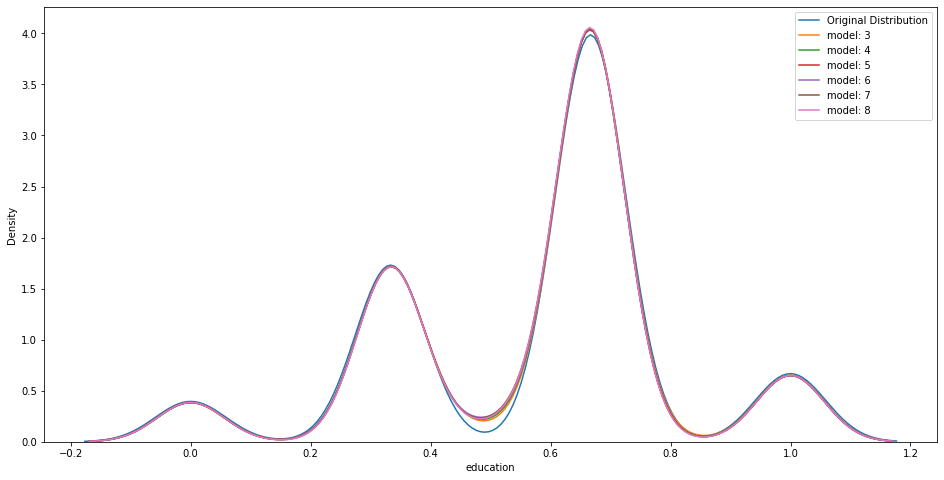

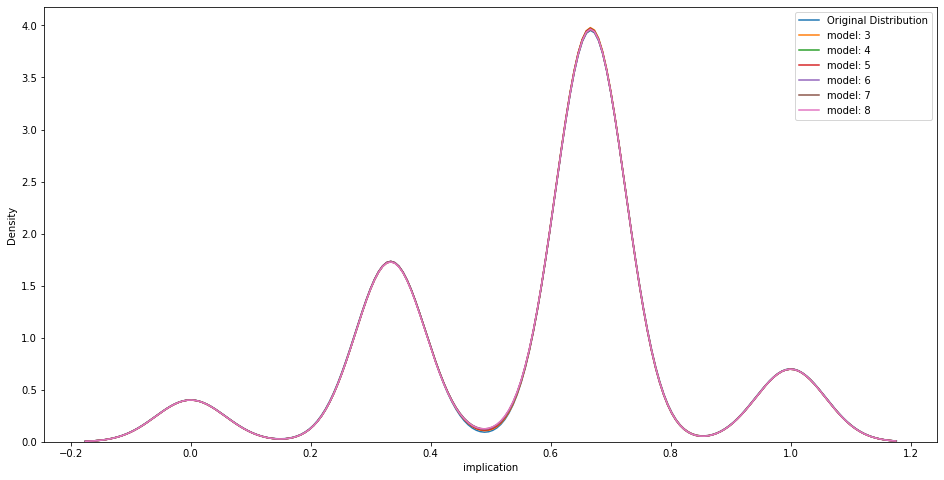

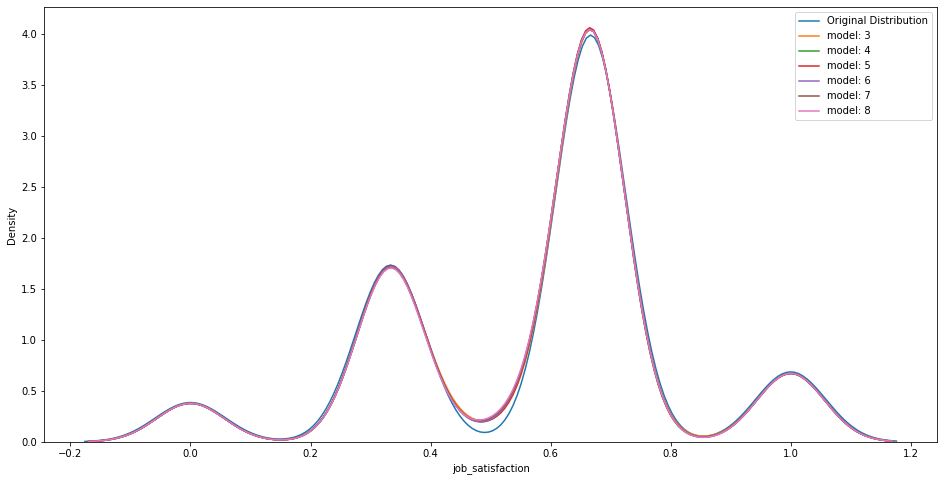

In [86]:
for column in ['education', 'implication', 'job_satisfaction']:
    sc_tr_x_train.missing.imputation.distribution_comparison_plot(knn_imputer, column)

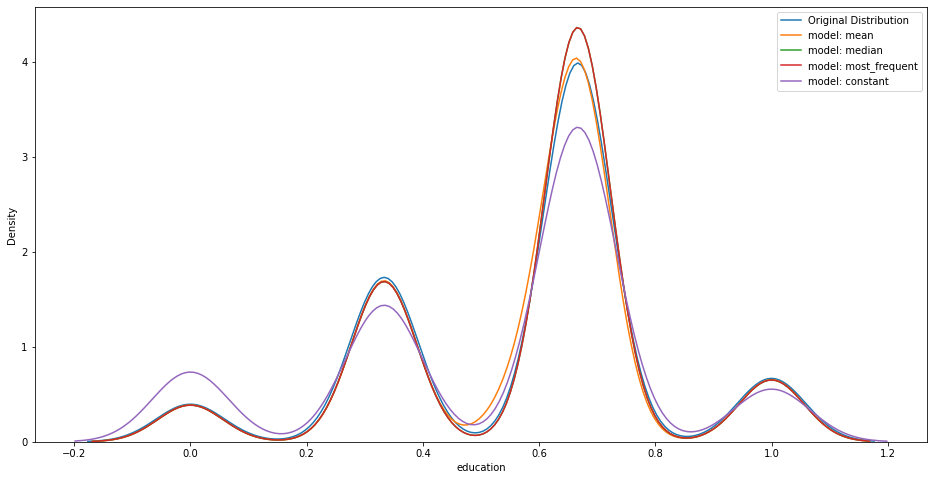

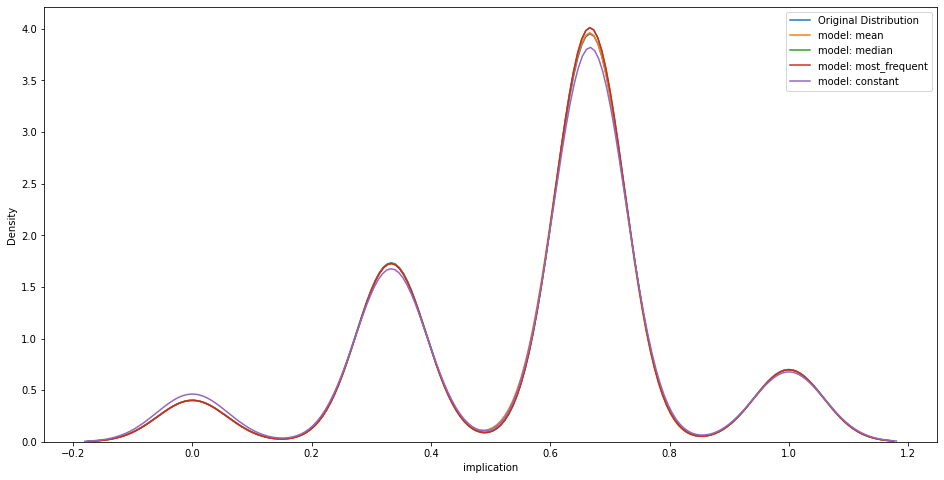

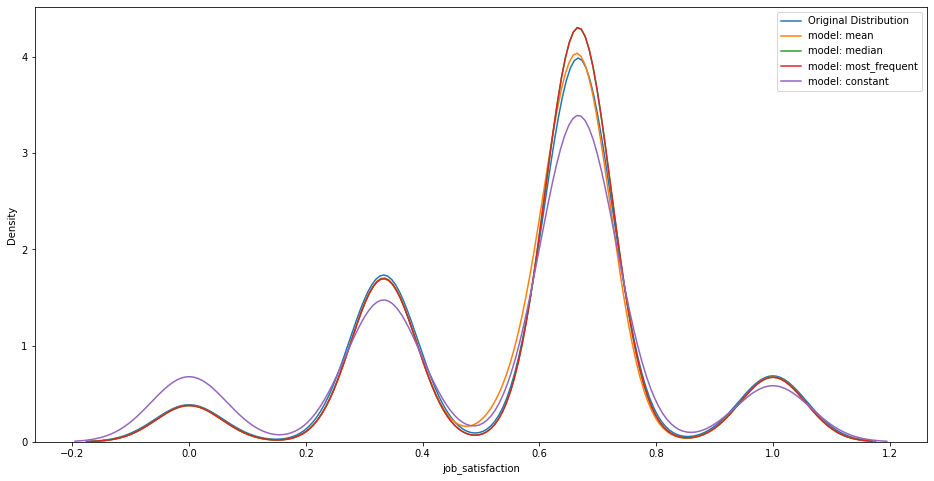

In [87]:
for column in ['education', 'implication', 'job_satisfaction']:
    sc_tr_x_train.missing.imputation.distribution_comparison_plot(simple_imputer, column)